basiert auf Touren, nicht Tour-Vektoren

In [1]:
import evrp
import random
import math
import matplotlib.pyplot as plt
import numpy as np
import time

path="../evrp-benchmark-set/"

In [2]:
instances=evrp.read_in_all_instances(path)
print(list(instances.keys()))

['X-n573-k30', 'X-n749-k98', 'X-n1001-k43', 'X-n214-k11', 'X-n143-k7', 'X-n819-k171', 'E-n101-k8', 'X-n916-k207', 'E-n23-k3', 'E-n51-k5', 'X-n351-k40', 'E-n33-k4', 'E-n76-k7', 'E-n30-k3', 'X-n685-k75', 'X-n459-k26', 'E-n22-k4']


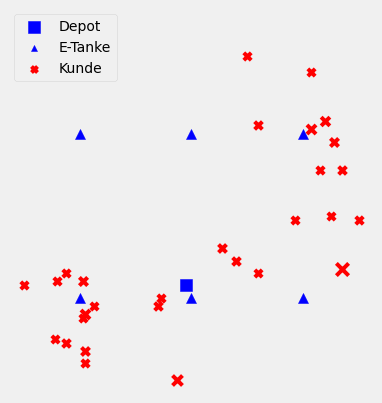

In [3]:
inst=instances['E-n30-k3']
evrp.show(inst)

## Genetischer Algorithmus

In [72]:
SELECTION_SIZE=3
RESET_RATE=0.25
MUTATE_NUM=3
MUTATION_RATE=0.25

def select(population,scores,tournament_size=SELECTION_SIZE):
    N=len(population)
    choice=random.sample(range(N),tournament_size)
    best=math.inf
    best_index=None
    for index in choice:
        if scores[index]<best:
            best=scores[index]
            best_index=index
    return population[best_index]

def strip_stations(tour,instance):
    new_tour=[]
    for vehicle_tour in tour:
        new_vehicle_tour=[stop for stop in vehicle_tour if stop in instance.customers and stop!=instance.depot]
        new_tour.append(new_vehicle_tour)
    return new_tour

def reset_stations(tour,instance):
    new_tour=strip_stations(tour,instance)
    evrp.fix_range(new_tour,instance)
    return new_tour

def move_mutation(tour):
    ### randomly move some stop to some other car / position
    vehicle_tour1=random.choice(tour)
    if len(vehicle_tour1)==0:
        return
    vehicle_tour2=random.choice(tour)
    pos1=random.randint(0,len(vehicle_tour1)-1) ## depot at start? no
    stop=vehicle_tour1.pop(pos1)
    pos2=random.randint(0,len(vehicle_tour2))
    vehicle_tour2.insert(pos2,stop)
    
def mutate(tour,instance):
    mutation=tour
    if random.random()<=RESET_RATE:
        mutation=reset_stations(tour,instance)
    for _ in range(MUTATE_NUM):
        if random.random()<=MUTATION_RATE:
            move_mutation(mutation)
    return mutation

def find_missing_and_doubles(child,instance):
    doubles=[]
    counted=[instance.depot]
    for vehicle_tour in child:
        for stop in vehicle_tour:
            if stop in instance.customers:
                if stop in counted and stop!=instance.depot:
                    doubles.append(stop)
                else:
                    counted.append(stop)
    missing=[customer for customer in instance.customers if not customer in counted]
    return missing,doubles

def best_insert_single_missing(tour,missing,instance,tries=10):
    best=math.inf
    best_pos=None
    for _ in range(tries):
        vehicle_tour=random.choice(tour)
        pos=random.randint(0,len(vehicle_tour))
        vehicle_tour.insert(pos,missing)
        score=evrp.soft_objective_function([vehicle_tour],instance)
        if score<best:
            best=score
            best_pos=(vehicle_tour,pos)
        del vehicle_tour[pos]
    vehicle_tour,pos=best_pos
    vehicle_tour.insert(pos,missing)

def best_insert_all_missing(tour,missings,instance,tries=10):
    random.shuffle(missings)
    for m in missings:
        best_insert_single_missing(tour,m,instance,tries=tries)
        
def strip_doubles(child,exchanged_car,doubles):
    for i,vehicle_tour in enumerate(child):
        if i==exchanged_car:
            continue
        stripped=[stop for stop in vehicle_tour if not stop in doubles]
        child[i]=stripped
    
def fix(child,exchanged_car,instance):
    missings,doubles=find_missing_and_doubles(child,instance)
    strip_doubles(child,exchanged_car,doubles)
    best_insert_all_missing(child,missings,instance,tries=10)
    
def crossover(parent1,parent2,instance):
    ### exchange single vehicle
    first_car=random.randint(0,len(parent1)-1)
    second_car=random.randint(0,len(parent2)-1)
    child=deepcopy(parent1)  ## need to do deep copy
    child[first_car]=parent2[second_car].copy()
    fix(child,first_car,instance)
    return child

def compute_initial_population(instance,N):
    population=[]
    for _ in range(N):
        tour=evrp.rnd_tour(instance)
        evrp.fix_range(tour,instance)
        population.append(tour)
    return population
        
def compute_scores(population,instance):
    scores=[]
    for tour in population:
        score=evrp.soft_objective_function(tour,instance)
        scores.append(score)
    return scores

def update_best(best,best_animal,scores,population):
    for score,animal in zip(scores,population):
        if score<best:
            best=score
            best_animal=animal
    return best,best_animal

def deepcopy(tour):
    return [vehicle_tour.copy() for vehicle_tour in tour]

def genetic_algo(instance,N,time_budget,record=False):
    start=time.time()
    population=compute_initial_population(instance,N)
    best=math.inf
    best_animal=None
    pop_over_generations=[]
    generation=0
    while time.time()-start<time_budget:
        generation+=1
        scores=compute_scores(population,instance)
        if record:
            pop_over_generations.append(population)
        best,best_animal=update_best(best,best_animal,scores,population)
        child_population=[]
        for i in range(N):
            parent1=select(population,scores)
            parent2=select(population,scores)
            child=crossover(parent1,parent2,instance)
            child=mutate(child,instance)            
            child_population.append(child)
        population=child_population
    if record:
        print("time elapsed: {}s".format(round(time.time()-start)))
        print("number of generations: {}".format(len(scores_over_generations)))
        return best_animal,pop_over_generations
    return best_animal

In [73]:
gen_tour,pops=genetic_algo(inst,100,60,record=True)

time elapsed: 60s
number of generations: 225


In [11]:
evrp.vehicle_stats(gen_tour,inst)

,Auslastung,Ladungs-Min,#Ladehalts,Streckenlänge
Fahrzeug,,,,
1,2775.0,17.9,1.0,196.9
2,2450.0,39.3,1.0,170.3
3,4200.0,11.2,3.0,210.7
4,3325.0,8.2,1.0,212.9


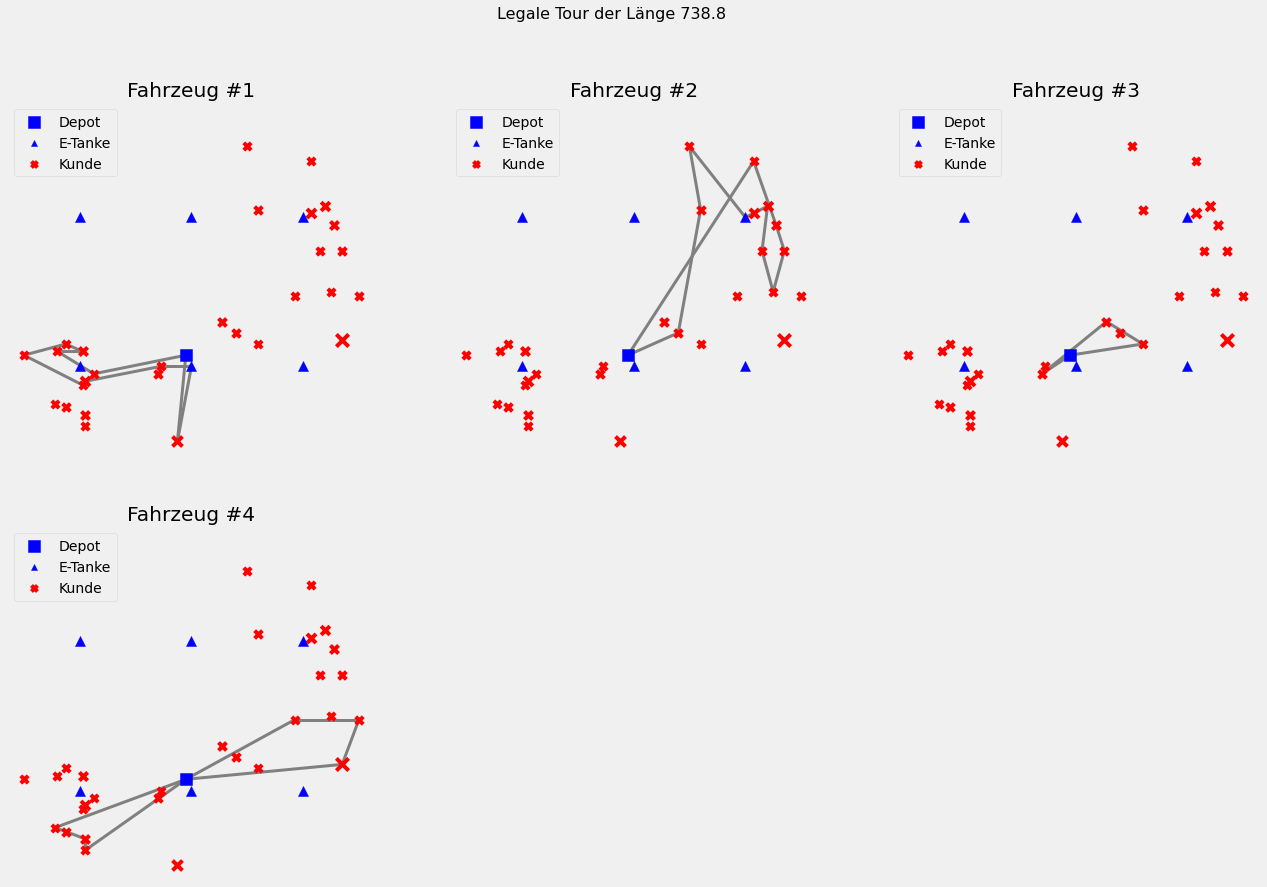

In [78]:
evrp.show(inst,tour=gen_tour)

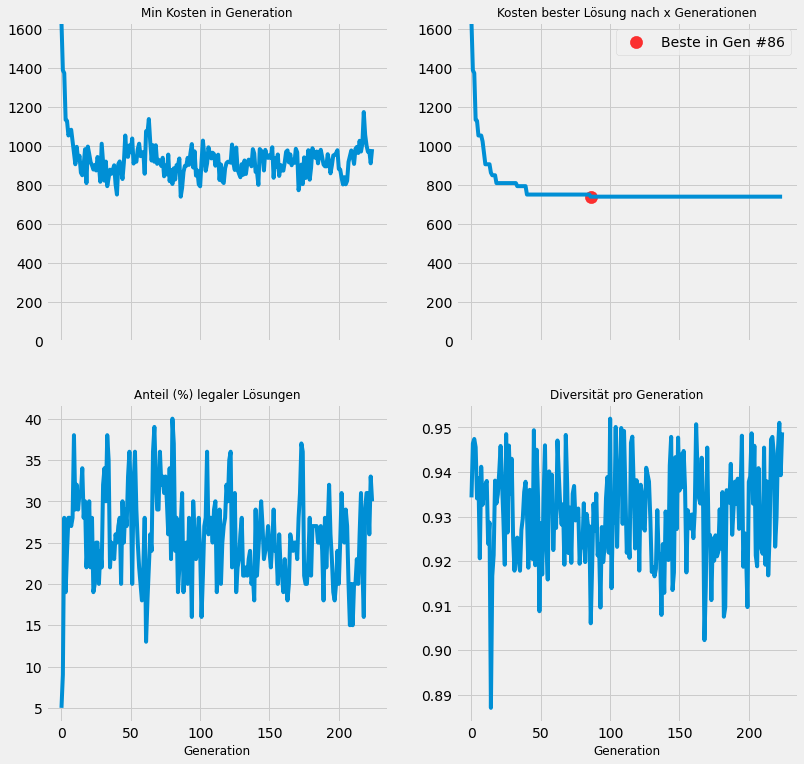

In [107]:
def get_edges(tour):
    edges=[]
    for vehicle_tour in tour:
        for i,_ in enumerate(vehicle_tour[:-1]):
            edges.append((vehicle_tour[i],vehicle_tour[i+1]))
    return edges
        
def similarity(tour1,tour2):
    edges1=get_edges(tour1)
    edges2=get_edges(tour2)
    return sum([1 for edge in edges1 if edge in edges2])/len(edges1)

def diversity(population,num_comparisons=100):
    common=0
    for _ in range(num_comparisons):
        tour1=random.choice(population)
        tour2=random.choice(population)
        common+=similarity(tour1,tour2)
    return 1-common/num_comparisons

def compute_scores_over_gens(pops_over_gens,instance):
    S=[]
    for pop in pops_over_gens:
        S.append([evrp.soft_objective_function(p,instance) for p in pop])
    return S

def compute_min_scores(scores_over_gens):
    return [min(scores) for scores in scores_over_gens]

def show_analytics(pops_over_gens,instance):
    FSIZE=12
    scores_over_gens=compute_scores_over_gens(pops_over_gens,instance)
    min_scores=compute_min_scores(scores_over_gens)
    ymax=max([score for score in min_scores if score<evrp.WEIGHT])
#    fig,axs=plt.subplots(1,4,figsize=(22,5))
    fig,axs=plt.subplots(2,2,figsize=(12,12),sharex=True)
    axs=axs.flat
    axs[0].plot(range(len(min_scores)),min_scores)
    axs[0].set_title("Min Kosten in Generation",fontsize=FSIZE)
    axs[0].set_ylim(0,ymax)
#    axs[0].set_xlabel("Generation",fontsize=FSIZE)
    
    axs[1].plot(range(len(min_scores)),[min(min_scores[:n+1]) for n in range(len(min_scores))])
    axs[1].set_title("Kosten bester Lösung nach x Generationen",fontsize=FSIZE)
    axs[1].set_ylim(0,ymax)
#    axs[1].set_xlabel("Generation",fontsize=FSIZE)
    min_gen=np.argmin(min_scores)
    axs[1].scatter([min_gen],[min_scores[min_gen]],color='r',s=150,alpha=0.8,label="Beste in Gen #{}".format(min_gen))
    axs[1].legend()


    N=len(pops_over_gens[0])
    valid_rate=[sum([1 for score in scores if score<evrp.WEIGHT])/N*100 for scores in scores_over_gens]
    axs[2].plot(range(len(valid_rate)),valid_rate)
    axs[2].set_title("Anteil (%) legaler Lösungen",fontsize=FSIZE)
    axs[2].set_xlabel("Generation",fontsize=FSIZE)

    divs=[diversity(pop) for pop in pops_over_gens]
    axs[3].plot(range(len(divs)),divs)
    axs[3].set_title("Diversität pro Generation",fontsize=FSIZE)
    axs[3].set_xlabel("Generation",fontsize=FSIZE)
    
    plt.show()
    
show_analytics(pops,inst)